# Predicting Style Probability by Painting Features

Author: Yangyu Wang, Gio Choi, Avi Oberoi

Date: 02/11/2025

## Table of Contents

1. [Data Preprocessing](#Data-Preprocessing)
2. [Tree-based Model](#Tree-based-Model:-Random-Forest)
3. [Linear Model](#Linear-Model)
4. [Model Comparison & Results](#Model-Comparison-&-Results)

## Data Preprocessing

In [1]:
#Avi, Please add your code here

## EDA

1. Processing data

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [3]:
painting_feature = pd.read_csv("data/artwork_with_clip_features.csv")

In [4]:
def string_to_array(s):
    '''
    Change the string-like array into numpy.array
    Parameter:
        s: string to change with an array structure
    Output: array
    '''
    return np.fromstring(s.strip("[]"), sep=" ").tolist()

painting_feature['Feature_array'] = painting_feature['Feature'].apply(string_to_array)

In [5]:
print(painting_feature['Feature_array'][0][0])

0.035522


In [6]:
len(set(painting_feature["Style_Category"]))

16

In [7]:
painting_feature.head()

,Artwork_ID,Artist_name,Year,image_n,Style_Category,Feature,Feature_array
0,9,a-y-jackson,1919,46467,Impressionism & Post-Impressionism,[ 3.5522e-02 -5.0446e-02 3.7323e-02 1.8173e-...,"[0.035522, -0.050446, 0.037323, 0.018173, -0.0..."
1,10,a-y-jackson,1918,73382,Art Nouveau & Deco,[-2.8248e-03 -2.7283e-02 2.2278e-02 1.8936e-...,"[-0.0028248, -0.027283, 0.022278, 0.018936, -0..."
2,11,a-y-jackson,1951,64112,Impressionism & Post-Impressionism,[ 3.4515e-02 -7.7515e-03 3.0270e-03 1.6342e-...,"[0.034515, -0.0077515, 0.003027, 0.016342, -0...."
3,12,a-y-jackson,1920,2173,Impressionism & Post-Impressionism,[-1.0796e-02 7.4120e-03 1.1635e-02 4.5807e-...,"[-0.010796, 0.007412, 0.011635, 0.045807, 0.00..."
4,13,a-y-jackson,1933,74330,Art Nouveau & Deco,[-1.3092e-02 -1.0653e-03 5.2887e-02 -4.5700e-...,"[-0.013092, -0.0010653, 0.052887, -0.00457, -0..."


Here we do not directly encode the Style_Category, because for tree-based and linear model, y should be encoded in different ways. Detailed processing on the y, please check each part.

2. Visualization

In [8]:
# Avi, could you add some dimension detection on features here?

Visualization by Years and Style categories

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
painting_feature_nondup = painting_feature.drop_duplicates("image_n")

In [11]:
yearly_counts = painting_feature_nondup.groupby("Year").size().reset_index(name="Artwork_Count")

In [12]:
yearly_counts["Year"] = yearly_counts["Year"].astype(int)

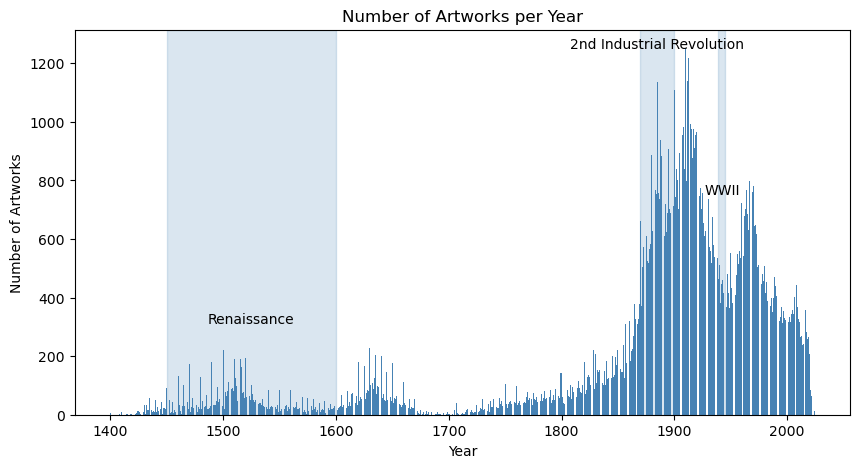

In [13]:
plt.figure(figsize=(10, 5))
ax = plt.bar(data=yearly_counts, x="Year", height="Artwork_Count", color="steelblue")

plt.xlabel("Year")
plt.ylabel("Number of Artworks")
plt.title("Number of Artworks per Year")

plt.axvspan(1450, 1600, color='steelblue', alpha=0.2)
plt.text(1525, yearly_counts["Artwork_Count"].max() * 0.25, "Renaissance", fontsize=10, color="black", ha='center')

plt.axvspan(1870, 1900, color='steelblue', alpha=0.2)
plt.text(1885, yearly_counts["Artwork_Count"].max() * 1, "2nd Industrial Revolution", fontsize=10, color="black", ha='center')

plt.axvspan(1939, 1945, color='steelblue', alpha=0.2)
plt.text(1942.5, yearly_counts["Artwork_Count"].max() * 0.6, "WWII", fontsize=10, color="black", ha='center')

plt.show()

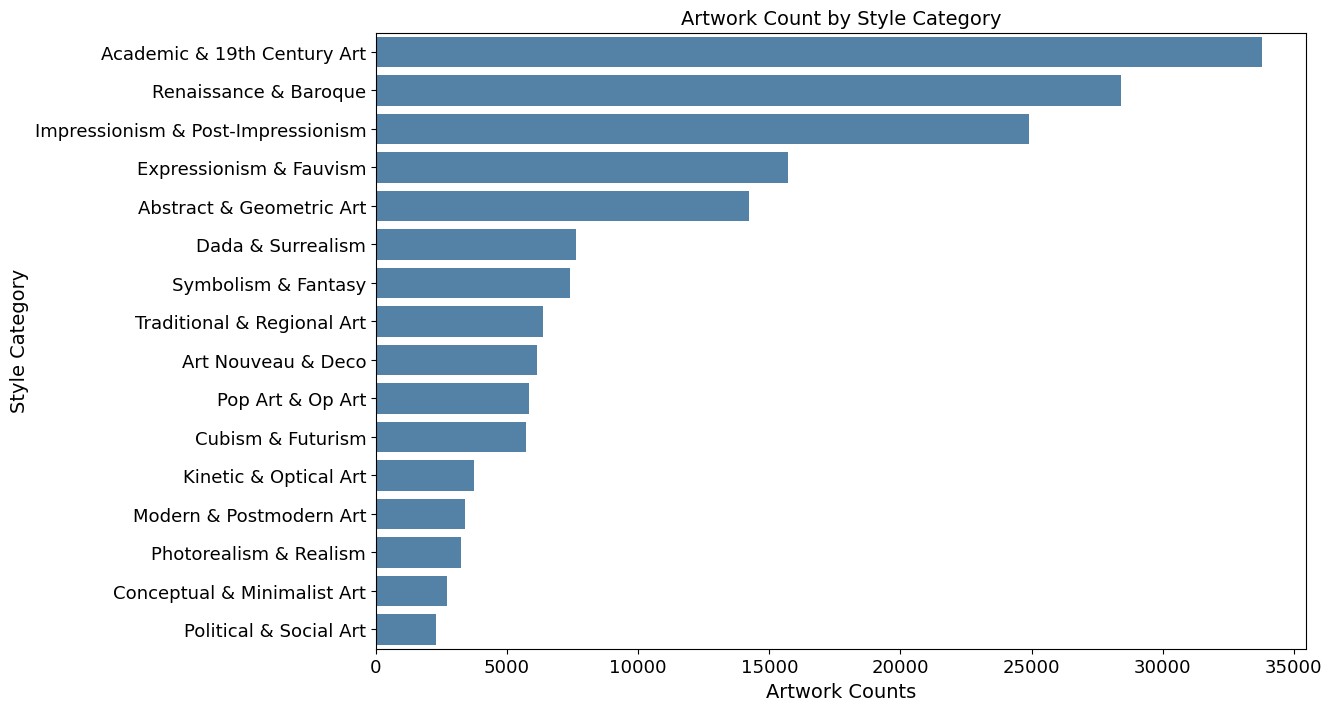

In [14]:
style_counts = painting_feature["Style_Category"].value_counts().reset_index()
style_counts.columns = ["Style_Category", "Count"]

plt.figure(figsize=(12, 8))
sns.barplot(data=style_counts, x="Count", y="Style_Category", color="steelblue")
plt.xlabel("Artwork Counts", fontsize=14)
plt.ylabel("Style Category", fontsize=14)
plt.title("Artwork Count by Style Category", fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

3. Split on training and testing dataset

Because of the imbalanced structure of our dataset, we sample 1800 for each categories to train the model and 400 to test.

In [15]:
train_samples = []
test_samples = []

for style, group in painting_feature.groupby('Style_Category'):
    train_sample, test_sample = train_test_split(group, train_size=1800, test_size=400, random_state=42, stratify=group['Style_Category'])
    print(style, len(group))
    
    train_samples.append(train_sample)
    test_samples.append(test_sample)

balanced_train_df = pd.concat(train_samples)
balanced_test_df = pd.concat(test_samples)


Abstract & Geometric Art 14217
Academic & 19th Century Art 33771
Art Nouveau & Deco 6144
Conceptual & Minimalist Art 2719
Cubism & Futurism 5709
Dada & Surrealism 7638
Expressionism & Fauvism 15717
Impressionism & Post-Impressionism 24896
Kinetic & Optical Art 3725
Modern & Postmodern Art 3381
Photorealism & Realism 3235
Political & Social Art 2292
Pop Art & Op Art 5821
Renaissance & Baroque 28405
Symbolism & Fantasy 7391
Traditional & Regional Art 6369


In [16]:
len(balanced_train_df)

28800

## Tree-based Model: Random Forest

1. Data processing

We chose label encoder here, for tree-based do not require any additional encoding to deal with tasks.

In [17]:
from sklearn.preprocessing import LabelEncoder

In [18]:
X_train = np.vstack(balanced_train_df["Feature_array"])
y_train = np.array(balanced_train_df['Style_Category'])

X_test = np.vstack(balanced_test_df["Feature_array"])
y_test = np.array(balanced_test_df['Style_Category'])

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (28800, 512), y_train shape: (28800,)
X_test shape: (6400, 512), y_test shape: (6400,)


2. Random Forest & Model Evaluation

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

In [20]:
rfc_base = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
rfc_base.fit(X_train, y_train)
np.round(rfc_base.score(X_test,y_test),3)

0.53

In [21]:
y_pred_rfc_base = rfc_base.predict(X_test)
y_probs_rfc_base = rfc_base.predict_proba(X_test)
confusion_matrix(y_test, y_pred_rfc_base, labels=rfc_base.classes_)

array([[178,   0,   5,  42,  19,  15,   2,   1,  94,  10,   4,   2,  21,
          0,   5,   2],
       [  0, 241,  21,   1,   0,   2,   3,  52,   0,   1,   4,   7,   1,
         55,   8,   4],
       [  2,  29, 208,   4,  13,   5,  18,  40,   1,   2,   3,  17,   4,
         11,  33,  10],
       [ 37,   0,   1, 277,   0,   3,   0,   0,  27,   5,   7,   6,  29,
          1,   4,   3],
       [ 20,   1,  12,   5, 264,  24,  28,   7,   9,   0,   4,   8,   6,
          0,   4,   8],
       [  9,  13,  12,  23,  68, 141,  11,   5,  29,   9,  15,  10,  16,
          3,  23,  13],
       [  5,  10,  21,   3,  42,  23, 148,  24,  29,  14,  14,  22,  10,
          2,  12,  21],
       [  0,  37,  22,   1,   8,   0,  24, 259,   1,   2,   9,   9,   1,
          5,  18,   4],
       [ 47,   0,   1,  26,  15,  11,   6,   1, 260,   1,   0,   0,  21,
          0,   4,   7],
       [ 14,   8,   6,  25,   7,  16,  29,  19,  17, 153,  43,  25,  16,
          4,   6,  12],
       [  2,  18,   5,  28,   

In [22]:
print(classification_report(y_test, y_pred_rfc_base, zero_division=np.nan))

                                    precision    recall  f1-score   support

          Abstract & Geometric Art       0.46      0.45      0.45       400
       Academic & 19th Century Art       0.52      0.60      0.56       400
                Art Nouveau & Deco       0.49      0.52      0.51       400
       Conceptual & Minimalist Art       0.54      0.69      0.60       400
                 Cubism & Futurism       0.56      0.66      0.61       400
                 Dada & Surrealism       0.44      0.35      0.39       400
           Expressionism & Fauvism       0.41      0.37      0.39       400
Impressionism & Post-Impressionism       0.52      0.65      0.58       400
             Kinetic & Optical Art       0.51      0.65      0.57       400
           Modern & Postmodern Art       0.57      0.38      0.46       400
            Photorealism & Realism       0.55      0.48      0.51       400
            Political & Social Art       0.55      0.51      0.52       400
           

In [23]:
roc_score_1 = roc_auc_score(y_test, y_probs_rfc_base, multi_class='ovo')
roc_score_1

0.9087259375

In [24]:
y_test_bin = label_binarize(y_test, classes=rfc_base.classes_)

roc_per_class_1 = roc_auc_score(y_test_bin, y_probs_rfc_base, average=None)

for style, roc in zip(rfc_base.classes_, roc_per_class_1):
    print("ROC-AUC for", style + ":", roc)

ROC-AUC for Abstract & Geometric Art: 0.9195724999999999
ROC-AUC for Academic & 19th Century Art: 0.935088125
ROC-AUC for Art Nouveau & Deco: 0.906696875
ROC-AUC for Conceptual & Minimalist Art: 0.9595010416666667
ROC-AUC for Cubism & Futurism: 0.9398983333333333
ROC-AUC for Dada & Surrealism: 0.8720070833333333
ROC-AUC for Expressionism & Fauvism: 0.8033860416666667
ROC-AUC for Impressionism & Post-Impressionism: 0.9354564583333332
ROC-AUC for Kinetic & Optical Art: 0.952171875
ROC-AUC for Modern & Postmodern Art: 0.86813125
ROC-AUC for Photorealism & Realism: 0.9072614583333334
ROC-AUC for Political & Social Art: 0.9113731249999999
ROC-AUC for Pop Art & Op Art: 0.8678291666666668
ROC-AUC for Renaissance & Baroque: 0.989599375
ROC-AUC for Symbolism & Fantasy: 0.870034375
ROC-AUC for Traditional & Regional Art: 0.9016079166666667


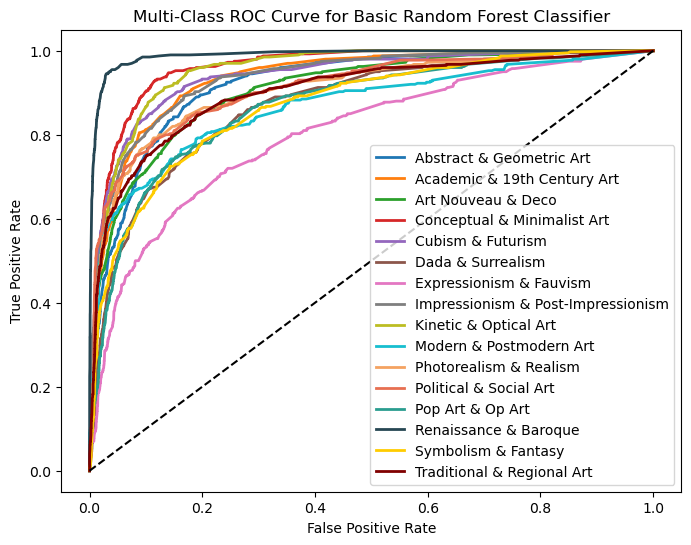

In [25]:
n_classes = len(rfc_base.classes_)

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
    "#bcbd22", "#17becf", "#f4a261", "#e76f51", "#2a9d8f", "#264653", "#ffcc00", "#800000"
]

plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs_rfc_base[:, i])
    plt.plot(fpr, tpr, lw=2, color=color, label=rfc_base.classes_[i])

plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve for Basic Random Forest Classifier")
plt.legend()
plt.show()

3. Grid search to fine tune the model

We try to change the __max_depth__ (the depth of trees), __max_features__ (maximum number of features used in single tree), and __max_samples__ (maximum number of samples used in single tree).

Here, we focus on the roc-auc of the model, because the model is not used to categorize paintings. Instead, the model is to generate prabilities. As a result, a higher roc-auc means the probabilities between difference labels have higher stratification, which is better for our task.

In [26]:
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

In [27]:
rfc = RandomForestClassifier(criterion='entropy', random_state=42)

param_grid = {
    'max_depth': [10, 20, None],
    'max_features': [5, 20, None],
    'max_samples': [0.5, 0.8, None]
}

param_list = list(ParameterGrid(param_grid))
print(f"Total parameter combinations: {len(param_list)}")

Total parameter combinations: 27


In [ ]:
best_params = None
best_test_auc = 0
best_rfc = None

with tqdm(param_list, desc="Grid Search Progress") as pbar:
    for params in pbar:
        rfc = RandomForestClassifier(**params, random_state=42)
        rfc.fit(X_train, y_train)

        y_pred_probs = rfc.predict_proba(X_test)
        test_auc = roc_auc_score(y_test, y_pred_probs, multi_class="ovo")

        pbar.set_postfix({"Test AUC": f"{test_auc:.4f}", "Previous Best AUC": f"{best_test_auc:.4f}"})

        if test_auc > best_test_auc:
            best_test_auc = test_auc
            best_params = params
            best_rfc = rfc

print("Best parameters:", best_params)
print(f"Best Test AUC: {best_test_auc:.4f}")

Grid Search Progress:  22%|██▏       | 6/27 [02:57<13:54, 39.74s/it, Test AUC=0.9126, Previous Best AUC=0.9117]

In [ ]:
np.round(best_rfc.score(X_test,y_test),3)

0.491

In [64]:
y_pred_best_rfc = best_rfc.predict(X_test)
y_probs_best_rfc = best_rfc.predict_proba(X_test)
confusion_matrix(y_test, y_pred_best_rfc, labels=best_rfc.classes_)

array([[ 70,   0,   1,  23,  13,   5,   6,   0,  56,   5,   3,   1,  12,
          0,   3,   2],
       [  0, 114,   9,   1,   0,   2,   3,  28,   1,   1,   4,   3,   2,
         29,   3,   0],
       [  1,  21,  89,   8,   5,   7,   5,  20,   2,   2,   2,  12,   2,
          5,  15,   4],
       [ 17,   0,   4, 134,   1,   1,   0,   0,   8,   2,   4,   8,  18,
          0,   1,   2],
       [  8,   0,   3,   3, 142,  12,  14,   5,   7,   0,   0,   2,   2,
          0,   2,   0],
       [  4,   3,   5,  17,  40,  71,   7,   3,  19,   4,   3,   6,   5,
          5,   5,   3],
       [  1,   6,   8,   4,  37,  10,  60,  24,  14,  11,   0,   5,   7,
          0,   9,   4],
       [  0,  23,   7,   0,   2,   0,   9, 144,   1,   0,   4,   1,   0,
          1,   7,   1],
       [ 24,   0,   0,  10,  10,   5,   1,   0, 140,   2,   1,   0,   6,
          0,   0,   1],
       [  6,   2,   5,  22,   0,   5,   5,  13,  25,  77,  12,  12,   4,
          4,   3,   5],
       [  3,  15,   1,  13,   

In [65]:
print(classification_report(y_test, y_pred_best_rfc, zero_division=np.nan))

                                    precision    recall  f1-score   support

          Abstract & Geometric Art       0.42      0.35      0.38       200
       Academic & 19th Century Art       0.48      0.57      0.52       200
                Art Nouveau & Deco       0.48      0.45      0.46       200
       Conceptual & Minimalist Art       0.47      0.67      0.55       200
                 Cubism & Futurism       0.50      0.71      0.59       200
                 Dada & Surrealism       0.45      0.35      0.40       200
           Expressionism & Fauvism       0.40      0.30      0.34       200
Impressionism & Post-Impressionism       0.48      0.72      0.58       200
             Kinetic & Optical Art       0.43      0.70      0.53       200
           Modern & Postmodern Art       0.49      0.39      0.43       200
            Photorealism & Realism       0.55      0.34      0.42       200
            Political & Social Art       0.48      0.46      0.47       200
           

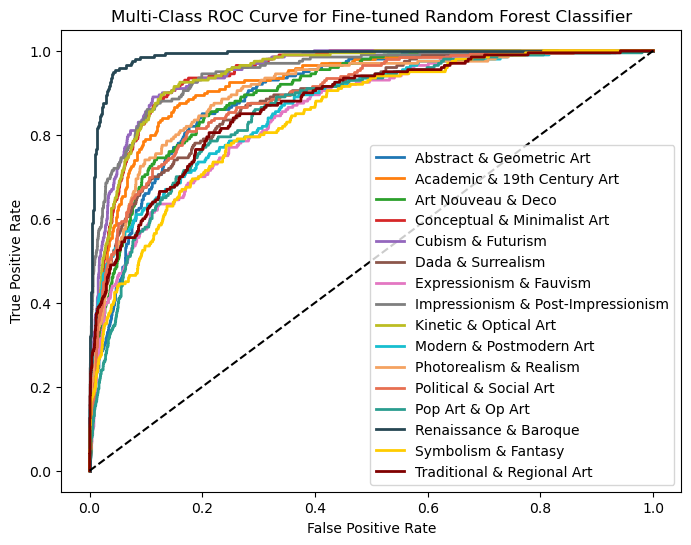

In [66]:
n_classes = len(best_rfc.classes_)

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
    "#bcbd22", "#17becf", "#f4a261", "#e76f51", "#2a9d8f", "#264653", "#ffcc00", "#800000"
]

plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs_best_rfc[:, i])
    plt.plot(fpr, tpr, lw=2, color=color, label=best_rfc.classes_[i])

plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve for Fine-tuned Random Forest Classifier")
plt.legend()
plt.show()

3. Interpretation: Visualize the first tree

In [ ]:
import graphviz 
from sklearn import tree

In [ ]:
# set names
feature_names = [f"Feature {i}" for i in range(X_train.shape[1])]
unique_classes = np.unique(y_train)
class_names = [str(cls) for cls in unique_classes]

In [ ]:
# try on the first tree
best_tree_example0 = best_rfc.estimators_[0]

In [ ]:
dot_data0 = tree.export_graphviz(best_tree_example0, out_file=None, 
                                feature_names=feature_names, 
                                class_names=class_names,  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph0 = graphviz.Source(dot_data0)  
graph0 

In [ ]:
tree_dict = {}

for i in range(len(best_rfc.estimators_[:5])):
    tree_case = best_rfc.estimators_[i]
    dot_data = tree.export_graphviz(tree_case, out_file=None, 
                                feature_names=feature_names, 
                                class_names=class_names,  
                                filled=True, rounded=True,  
                                special_characters=True)  
    graph = graphviz.Source(dot_data)  
    tree_dict[i] = graph

4. Error analysis

In [ ]:
confusion_matrix(y_test, y_pred_best_rfc, labels=best_rfc.classes_)

## Linear Model

## Model-Comparison-&-Results